In [1]:
%pip install imbalanced-learn
%pip install xgboost
%pip install shap

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
import seaborn as sns
import shap

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, recall_score, precision_score, f1_score, average_precision_score, precision_recall_curve
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline
from scipy.stats import kurtosis, skew
from imblearn.under_sampling import EditedNearestNeighbours

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


c:\Desktop\coding\MYDAC-Curriculum\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('../datasets/data.csv')

# Actual Model

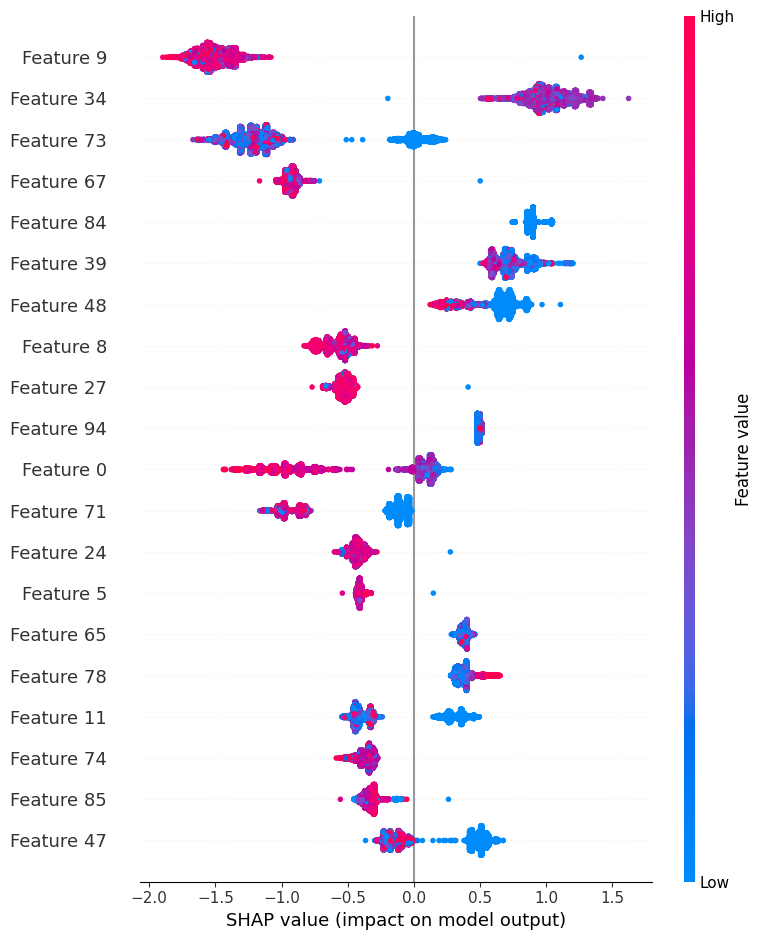

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99      1320
           1       0.98      1.00      0.99      1320

    accuracy                           0.99      2640
   macro avg       0.99      0.99      0.99      2640
weighted avg       0.99      0.99      0.99      2640


Confusion Matrix:
[[1287   33]
 [   1 1319]]


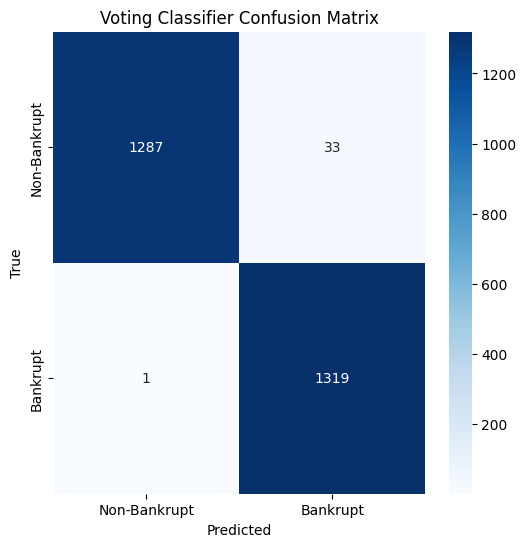

In [9]:
# Features and target
X = df.drop('Bankrupt?', axis=1)  # Features
y = df['Bankrupt?']  # Target (Bankrupt: 0 or 1)

# Handle missing values (in case it's not done yet)
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X[X > 1e10] = np.nan
X[X < -1e10] = np.nan

# Impute missing values with the median
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_imputed, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)

# Define models
rf_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42)

# Create a Voting Classifier to combine both models
voting_model = VotingClassifier(estimators=[
    ('rf', rf_model),
    ('xgb', xgb_model)
], voting='soft')

# Create a pipeline that includes SMOTE, imputation, scaling, and the ensemble model
pipeline = Pipeline([
    ('scaler', StandardScaler()),      # Standardize features
    ('voting_model', voting_model)     # Use the voting model (ensemble)
])

# Train the pipeline with the training data
pipeline.fit(X_train, y_train)




# Access the XGBoost model inside the pipeline
xgb_model = pipeline.named_steps['voting_model'].named_estimators_['xgb']
# Create a SHAP explainer for XGBoost
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)
# Plot SHAP summary plot
shap.summary_plot(shap_values, X_train)





# Make predictions with the trained pipeline
y_pred = pipeline.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Bankrupt', 'Bankrupt'], yticklabels=['Non-Bankrupt', 'Bankrupt'])
plt.title('Voting Classifier Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()